# **Finding the lane lines** 
***
The goal of this notebook is to identify and mark the area of the road between the lane lines on a dash-cam video.  It is separated into 5 parts:
1. Get the camera undistort coefficients
2. Define the computer vision helper functions
3. Define functions to find and draw lines with polynomial regression
4. Execute the pipeline on test images
5. Execute the pipeline on the video 
---

# **Part 1: Get the camera undistort coefficients** 
***
First, I used chessboard images to identify the undistortion coefficients of the camera lens, which will later be used in the pipeline.

---

In [405]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

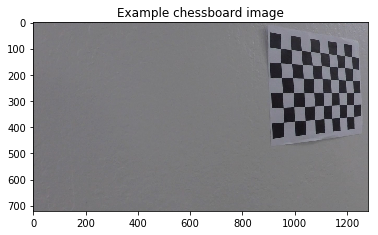

In [406]:
#Open the ~20 chessboard images and prepare lists for undistortion
images = glob.glob('camera_cal/*')
plt.title('Example chessboard image')
plt.imshow(mpimg.imread(images[7]))

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


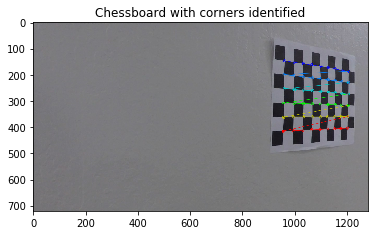

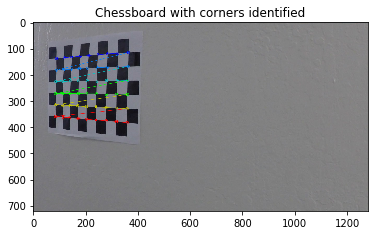

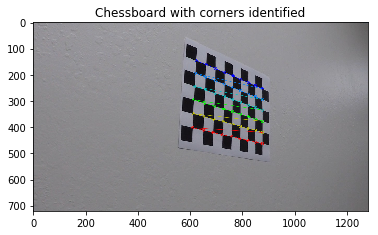

In [407]:
# Identify the corners in the chessboard images
incomplete_images = [0,14,15] # don't contain full chessboard

for i,image in enumerate(images):
    if i in incomplete_images: continue
    image = mpimg.imread(image)
    gray  = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        plt.title('Chessboard with corners identified')
        plt.imshow(img)
        if (i%5==0): plt.show() # show a few examples


In [408]:
# Define and run the function to get the undistort coefficients
def get_undistort_coefficients_and_matrix(images,x_points,y_points,incomplete_image_list):
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    objp = np.zeros((y_points*x_points,3),np.float32)
    objp[:,:2] = np.mgrid[0:x_points,0:y_points].T.reshape(-1,2)

    for i,image in enumerate(images):
        if i in incomplete_image_list: continue
        image = mpimg.imread(image)
        gray  = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (x_points,y_points),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(image, (x_points,y_points), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx,dist


In [409]:
# Save MTX and DIST for later use
MTX,DIST = get_undistort_coefficients_and_matrix(images,6,9,[0,14,15])

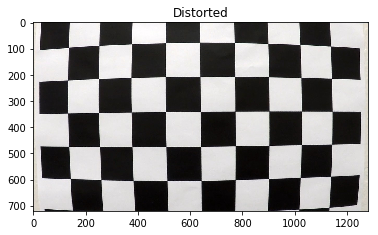

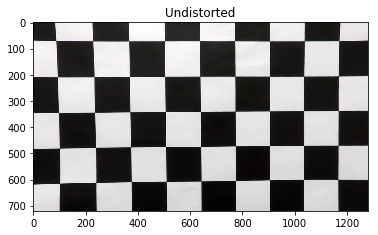

In [410]:
# Test the camera coefficients with an example
test_image = mpimg.imread(image_paths[0])
test_dst = cv2.undistort(test_image, MTX, DIST, None, MTX)
plt.title('Distorted')
plt.imshow(test_image)
plt.show()
plt.title('Undistorted')
plt.imshow(test_dst)

# **Part 2: Define the computer vision helper functions** 
***
This part defines one function for Sobel edge detection, which outputs a binary black and white image depending on the desired threshold, and another function that converts the image to the HLS color space to take advantage of the S-channel.  In the pipeline the two will be used together with 'or' logic.

---

In [411]:
# Define method that applies a Sobel filter and outputs a binary edge-detecting image
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output

In [412]:
# Define a method to convert the image from RGB to HLS to utilize the S Channel
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# **Part 3: Define functions to find and draw lines with polynomial regression** 
***
The first method uses quadratic regression and a sliding window technique to find lane lines.  The second maps the perspective-transformed image with lane lanes added back to its orginal form.  Both are needed in the pipeline.

---

In [413]:
# Define a method to find lane lines with quadratic regression
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result,leftx,rightx,lefty,righty,left_fitx,right_fitx,ploty

In [414]:
# Define a method to return the image to the original perspective
def add_lines_to_original_perspective(left_fitx,right_fitx,ploty,original_img,warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,200,100))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result


# **Part 4: Execute the pipeline on test images** 
***

This part runs every step of the pipeline on all 6 test images and saves them to disk.  Two examples are show in full.

---

In [415]:
# Save test image paths to a file
road_image_paths = glob.glob('./test_images/test*.jpg')

# Make lambda for generating pathnames
path_builder = lambda i,s : ('./test_images/'+s+'-'+str(i+1)+'.jpg')

# Define constants needed for curvature
YM_PER_PIX = 30/720 # meters per pixel in y dimension
XM_PER_PIX = 3.7/700 # meters per pixel in x dimension

# Apply the pipeline
for idx,road_image_path in enumerate(road_image_paths):
    
    #**************************************#
    #********* STEP 1: UNDISTORT **********#
    #**************************************#
    img = cv2.imread(road_image_path)
    img = cv2.undistort(img, MTX, DIST, None, MTX)
    cv2.imwrite(path_builder(idx,'undistort'),img)

    #**************************************#
    #********* STEP 2: SOBEL **************#
    #**************************************#
    sobel_img = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img,'x',10,255)   
    grady = abs_sobel_thresh(img,'y',10,255)
    sobel_img[(gradx == 1) & (grady == 1)] = 255
    cv2.imwrite(path_builder(idx,'sobel'),sobel_img)    
    
    #**************************************#
    #********* STEP 3: HLS ****************#
    #**************************************#
    hls_img = np.zeros_like(img[:,:,0])
    hls_binary = hls_select(img,(100,255))
    hls_img[hls_binary == 1] = 255
    cv2.imwrite(path_builder(idx,'hls'),hls_img)
    
    #**************************************#
    #******** STEP 4: SOBEL OR HLS ********#
    #**************************************#    
    sobel_or_hls_img = np.zeros_like(img[:,:,0])
    sobel_or_hls_img[sobel_img == 255] = 255
    sobel_or_hls_img[hls_img == 255] = 255
    cv2.imwrite(path_builder(idx,'sobel_or_hls'),sobel_or_hls_img)

    #**************************************#
    #******** STEP 5: WARP PERSPECTIVE ****#
    #**************************************#       
    img_size = (img.shape[1], gray.shape[0])
    src = np.float32([[585,460],[695,460] , [1120,720],[200,720] ])
    dst = np.float32([[280, 0], [1000,0], [1080,720], [280,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)    
    warp_img = cv2.warpPerspective(sobel_or_hls_img, M, img_size,flags=cv2.INTER_LINEAR)
    cv2.imwrite(path_builder(idx,'warp'),warp_img)
    
    #**************************************#
    #******** STEP 6: SLIDING WINDOW ******#
    #**************************************#         
    result,leftx,rightx,lefty,righty,left_fitx,right_fitx,ploty = sliding_window(warp_img)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig(path_builder(idx,'sliding_window'))
    plt.close()
    
    #**************************************#
    #******** STEP 7: CURVATURE ***********#
    #**************************************#         
    mark_size = 1
    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.savefig(path_builder(idx,'curvature'))    
    plt.close()

    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*720*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*720*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #**************************************#
    #******** STEP 8: LINED ORIGINAL ******#
    #**************************************#        
    lined_original_img = add_lines_to_original_perspective(left_fitx,right_fitx,ploty,img,warp_img)
    cv2.putText(lined_original_img, 'Curve Radius: {}m'.format(int(left_curverad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    cv2.imwrite(path_builder(idx,'lined_original'),lined_original_img)



  app.launch_new_instance()



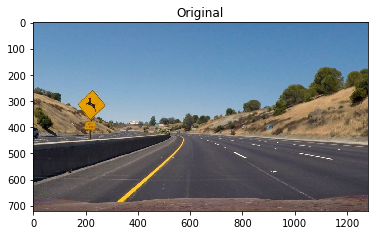

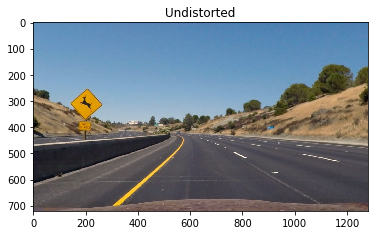

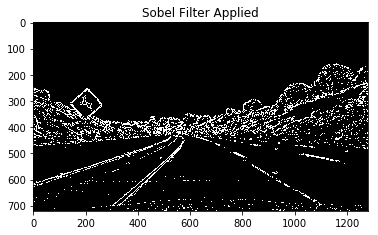

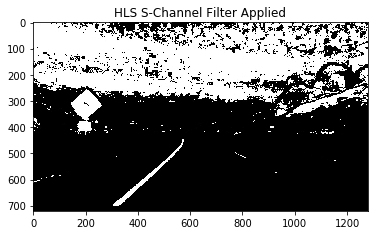

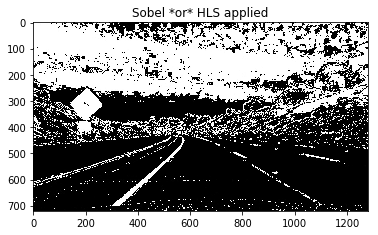

In [416]:
# Show an example image every step of the way

plt.imshow(plt.imread('./test_images/test2.jpg'))
plt.title('Original')
plt.show()

plt.imshow(plt.imread(path_builder(1,'undistort')))
plt.title('Undistorted')
plt.show()

plt.title('Sobel Filter Applied')
plt.imshow(cv2.imread(path_builder(1,'sobel')))
plt.show()

plt.title('HLS S-Channel Filter Applied')
plt.imshow(cv2.imread(path_builder(1,'hls')))
plt.show()

plt.title('Sobel *or* HLS applied')
plt.imshow(cv2.imread(path_builder(1,'sobel_or_hls')))
plt.show()


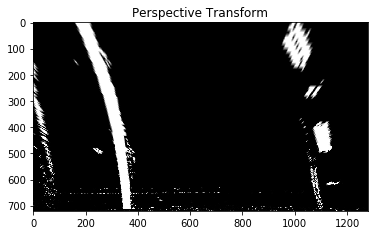

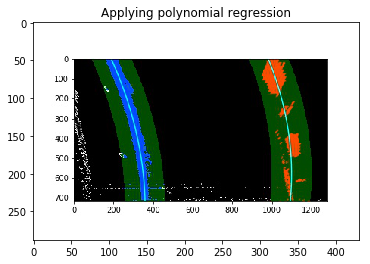

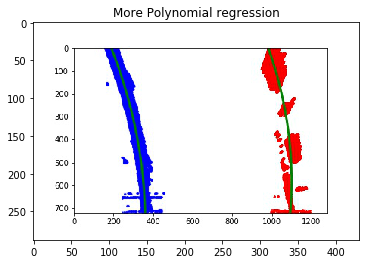

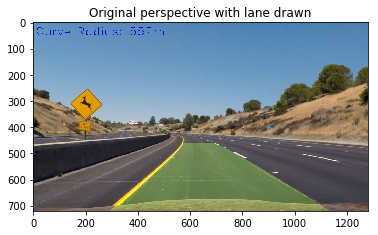

In [417]:
plt.title('Perspective Transform')
plt.imshow(cv2.imread(path_builder(1,'warp')))
plt.show()

plt.title('Applying polynomial regression')
plt.imshow(cv2.imread(path_builder(1,'sliding_window')))
plt.show()

plt.title('More Polynomial regression')
plt.imshow(cv2.imread(path_builder(1,'curvature')))
plt.show()

plt.title('Original perspective with lane drawn')
plt.imshow(plt.imread(path_builder(1,'lined_original')))
plt.show()

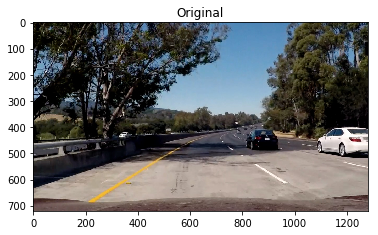

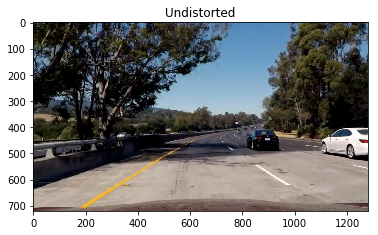

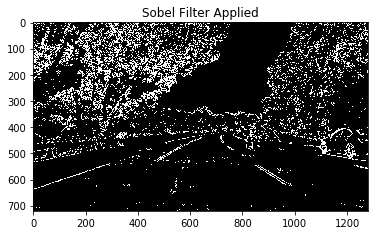

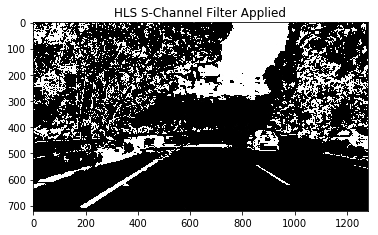

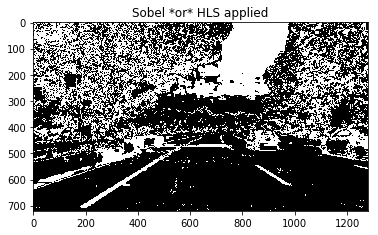

In [418]:
# Show one more example, the whole step of the way

plt.imshow(plt.imread('./test_images/test5.jpg'))
plt.title('Original')
plt.show()

plt.imshow(plt.imread(path_builder(4,'undistort')))
plt.title('Undistorted')
plt.show()

plt.title('Sobel Filter Applied')
plt.imshow(cv2.imread(path_builder(4,'sobel')))
plt.show()

plt.title('HLS S-Channel Filter Applied')
plt.imshow(cv2.imread(path_builder(4,'hls')))
plt.show()

plt.title('Sobel *or* HLS applied')
plt.imshow(cv2.imread(path_builder(4,'sobel_or_hls')))
plt.show()


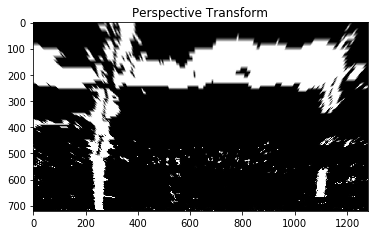

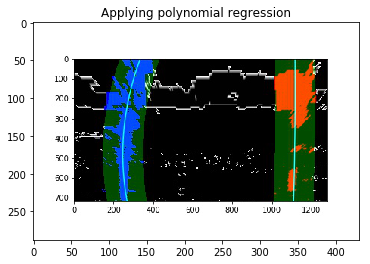

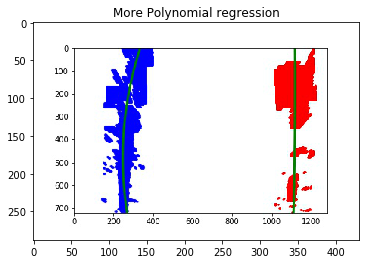

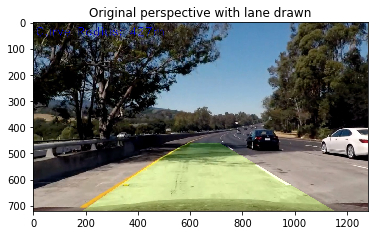

In [419]:
plt.title('Perspective Transform')
plt.imshow(cv2.imread(path_builder(4,'warp')))
plt.show()

plt.title('Applying polynomial regression')
plt.imshow(cv2.imread(path_builder(4,'sliding_window')))
plt.show()

plt.title('More Polynomial regression')
plt.imshow(cv2.imread(path_builder(4,'curvature')))
plt.show()

plt.title('Original perspective with lane drawn')
plt.imshow(plt.imread(path_builder(4,'lined_original')))
plt.show()

# **Part 5: Execute the pipeline on the video** 
***
This part applies the same pipeline to each image of the video and shows the result.

---

In [420]:
# Add the above process to a method (without saving intermediate images along the way)
def process_image(original_image):
    #**************************************#
    #********* STEP 1: UNDISTORT **********#
    #**************************************#    
    img = cv2.undistort(original_image, MTX, DIST, None, MTX)

    #**************************************#
    #********* STEP 2: SOBEL **************#
    #**************************************#
    sobel_img = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img,'x',10,255)   
    grady = abs_sobel_thresh(img,'y',10,255)
    sobel_img[(gradx == 1) & (grady == 1)] = 255
    
    #**************************************#
    #********* STEP 3: HLS ****************#
    #**************************************#
    hls_img = np.zeros_like(img[:,:,0])
    hls_binary = hls_select(img,(100,255))
    hls_img[hls_binary == 1] = 255
    
    #**************************************#
    #******** STEP 4: SOBEL OR HLS ********#
    #**************************************#    
    sobel_or_hls_img = np.zeros_like(img[:,:,0])
    sobel_or_hls_img[sobel_img == 255] = 255
    sobel_or_hls_img[hls_img == 255] = 255

    #**************************************#
    #******** STEP 5: WARP PERSPECTIVE ****#
    #**************************************#       
    img_size = (img.shape[1], gray.shape[0])
    src = np.float32([[585,460],[695,460] , [1120,720],[200,720] ])
    dst = np.float32([[280, 0], [1000,0], [1080,720], [280,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)    
    warp_img = cv2.warpPerspective(sobel_or_hls_img, M, img_size,flags=cv2.INTER_LINEAR)

    
    #**************************************#
    #******** STEP 6: SLIDING WINDOW ******#
    #**************************************#         
    result,leftx,rightx,lefty,righty,left_fitx,right_fitx,ploty = sliding_window(warp_img)

    #**************************************#
    #******** STEP 7: CURVATURE ***********#
    #**************************************#         
    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*720*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*720*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mean_curverad = (left_curverad + right_curverad)/2

    #**************************************#
    #******** STEP 8: LINED ORIGINAL ******#
    #**************************************#        
    lined_original_img = add_lines_to_original_perspective(left_fitx,right_fitx,ploty,img,warp_img)
    cv2.putText(lined_original_img, 'Curve Radius: {}m'.format(int(mean_curverad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    return lined_original_img

In [421]:
# Apply the pipleline to the example video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)


  self.nchannels))

  app.launch_new_instance()



[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/Users/zacharynagler/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

100%|█████████▉| 1260/1261 [03:44<00:00,  5.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 4s, sys: 44.1 s, total: 4min 48s
Wall time: 3min 46s


In [422]:
HTML("""
<video width="960" height="540" controls> 
  <source src="{0}">
</video>
""".format(output))